In [14]:
import os
import shutil
from tqdm import tqdm
from model_training.measures import summary, confusion_matrix
from backend.intercom_classifier import WordAudioClassifier
import scienceplots
import matplotlib.pyplot as plt
import numpy as np

plt.style.use(['science', 'ieee'])

## Convert Collected Data to Required File Structure

In [2]:
def split_files_by_category(input_path, output_path):
    """
    Splits files into subfolders based on the {word} part of their filenames.
    
    Parameters:
        input_path (str): Path to the input directory containing files to split.
        output_path (str): Path to the output directory where subfolders will be created.
    """
    if not os.path.exists(input_path):
        print(f"Error: Input path '{input_path}' does not exist.")
        return

    os.makedirs(output_path, exist_ok=True)

    for filename in tqdm(os.listdir(input_path)):
        file_path = os.path.join(input_path, filename)

        if not os.path.isfile(file_path):
            continue

        try:
            base_name, _ = os.path.splitext(filename)
            word, _ = base_name.split("_")
        except ValueError:
            print(f"Skipping file '{filename}' (does not match the required pattern).")
            continue

        category_folder = os.path.join(output_path, word)
        os.makedirs(category_folder, exist_ok=True)

        destination_path = os.path.join(category_folder, filename)
        shutil.copy(file_path, destination_path)

In [3]:
split_files_by_category('../data/manual', '../data/manual_split')

100%|██████████| 120/120 [00:00<00:00, 641.81it/s]


## Evaluate the Model on Collected Data

In [4]:
CLASS_LABELS = os.listdir('../data/manual_split')

classifier = WordAudioClassifier(
    class_labels=CLASS_LABELS,
    model_path="../models/robustness_3_single_cnn_tsrc_spectrograms_cleaned_augmented_sharpened/",
)

Model loaded successfully


In [5]:
y_true = []
y_pred = []

for word in tqdm(CLASS_LABELS):
    word_folder = os.path.join('../data/manual_split', word)
    for file in os.listdir(word_folder):
        file_path = os.path.join(word_folder, file)
        predicted_label = classifier.predict_word(file_path)

        y_true.append(CLASS_LABELS.index(word))
        y_pred.append(CLASS_LABELS.index(predicted_label))

  0%|          | 0/30 [00:00<?, ?it/s]E:\MINI8\ITM\intro-to-ml\backend\audio_cleaner.py:37: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(input_path, sr=None)
e:\MINI8\ITM\intro-to-ml\venv\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|██████████| 30/30 [00:43<00:00,  1.45s/it]


Accuracy: 0.875
Micro F1 Score: 0.875
Macro F1 Score: 0.8665343915343916
Weighted F1 Score: 0.8665343915343915


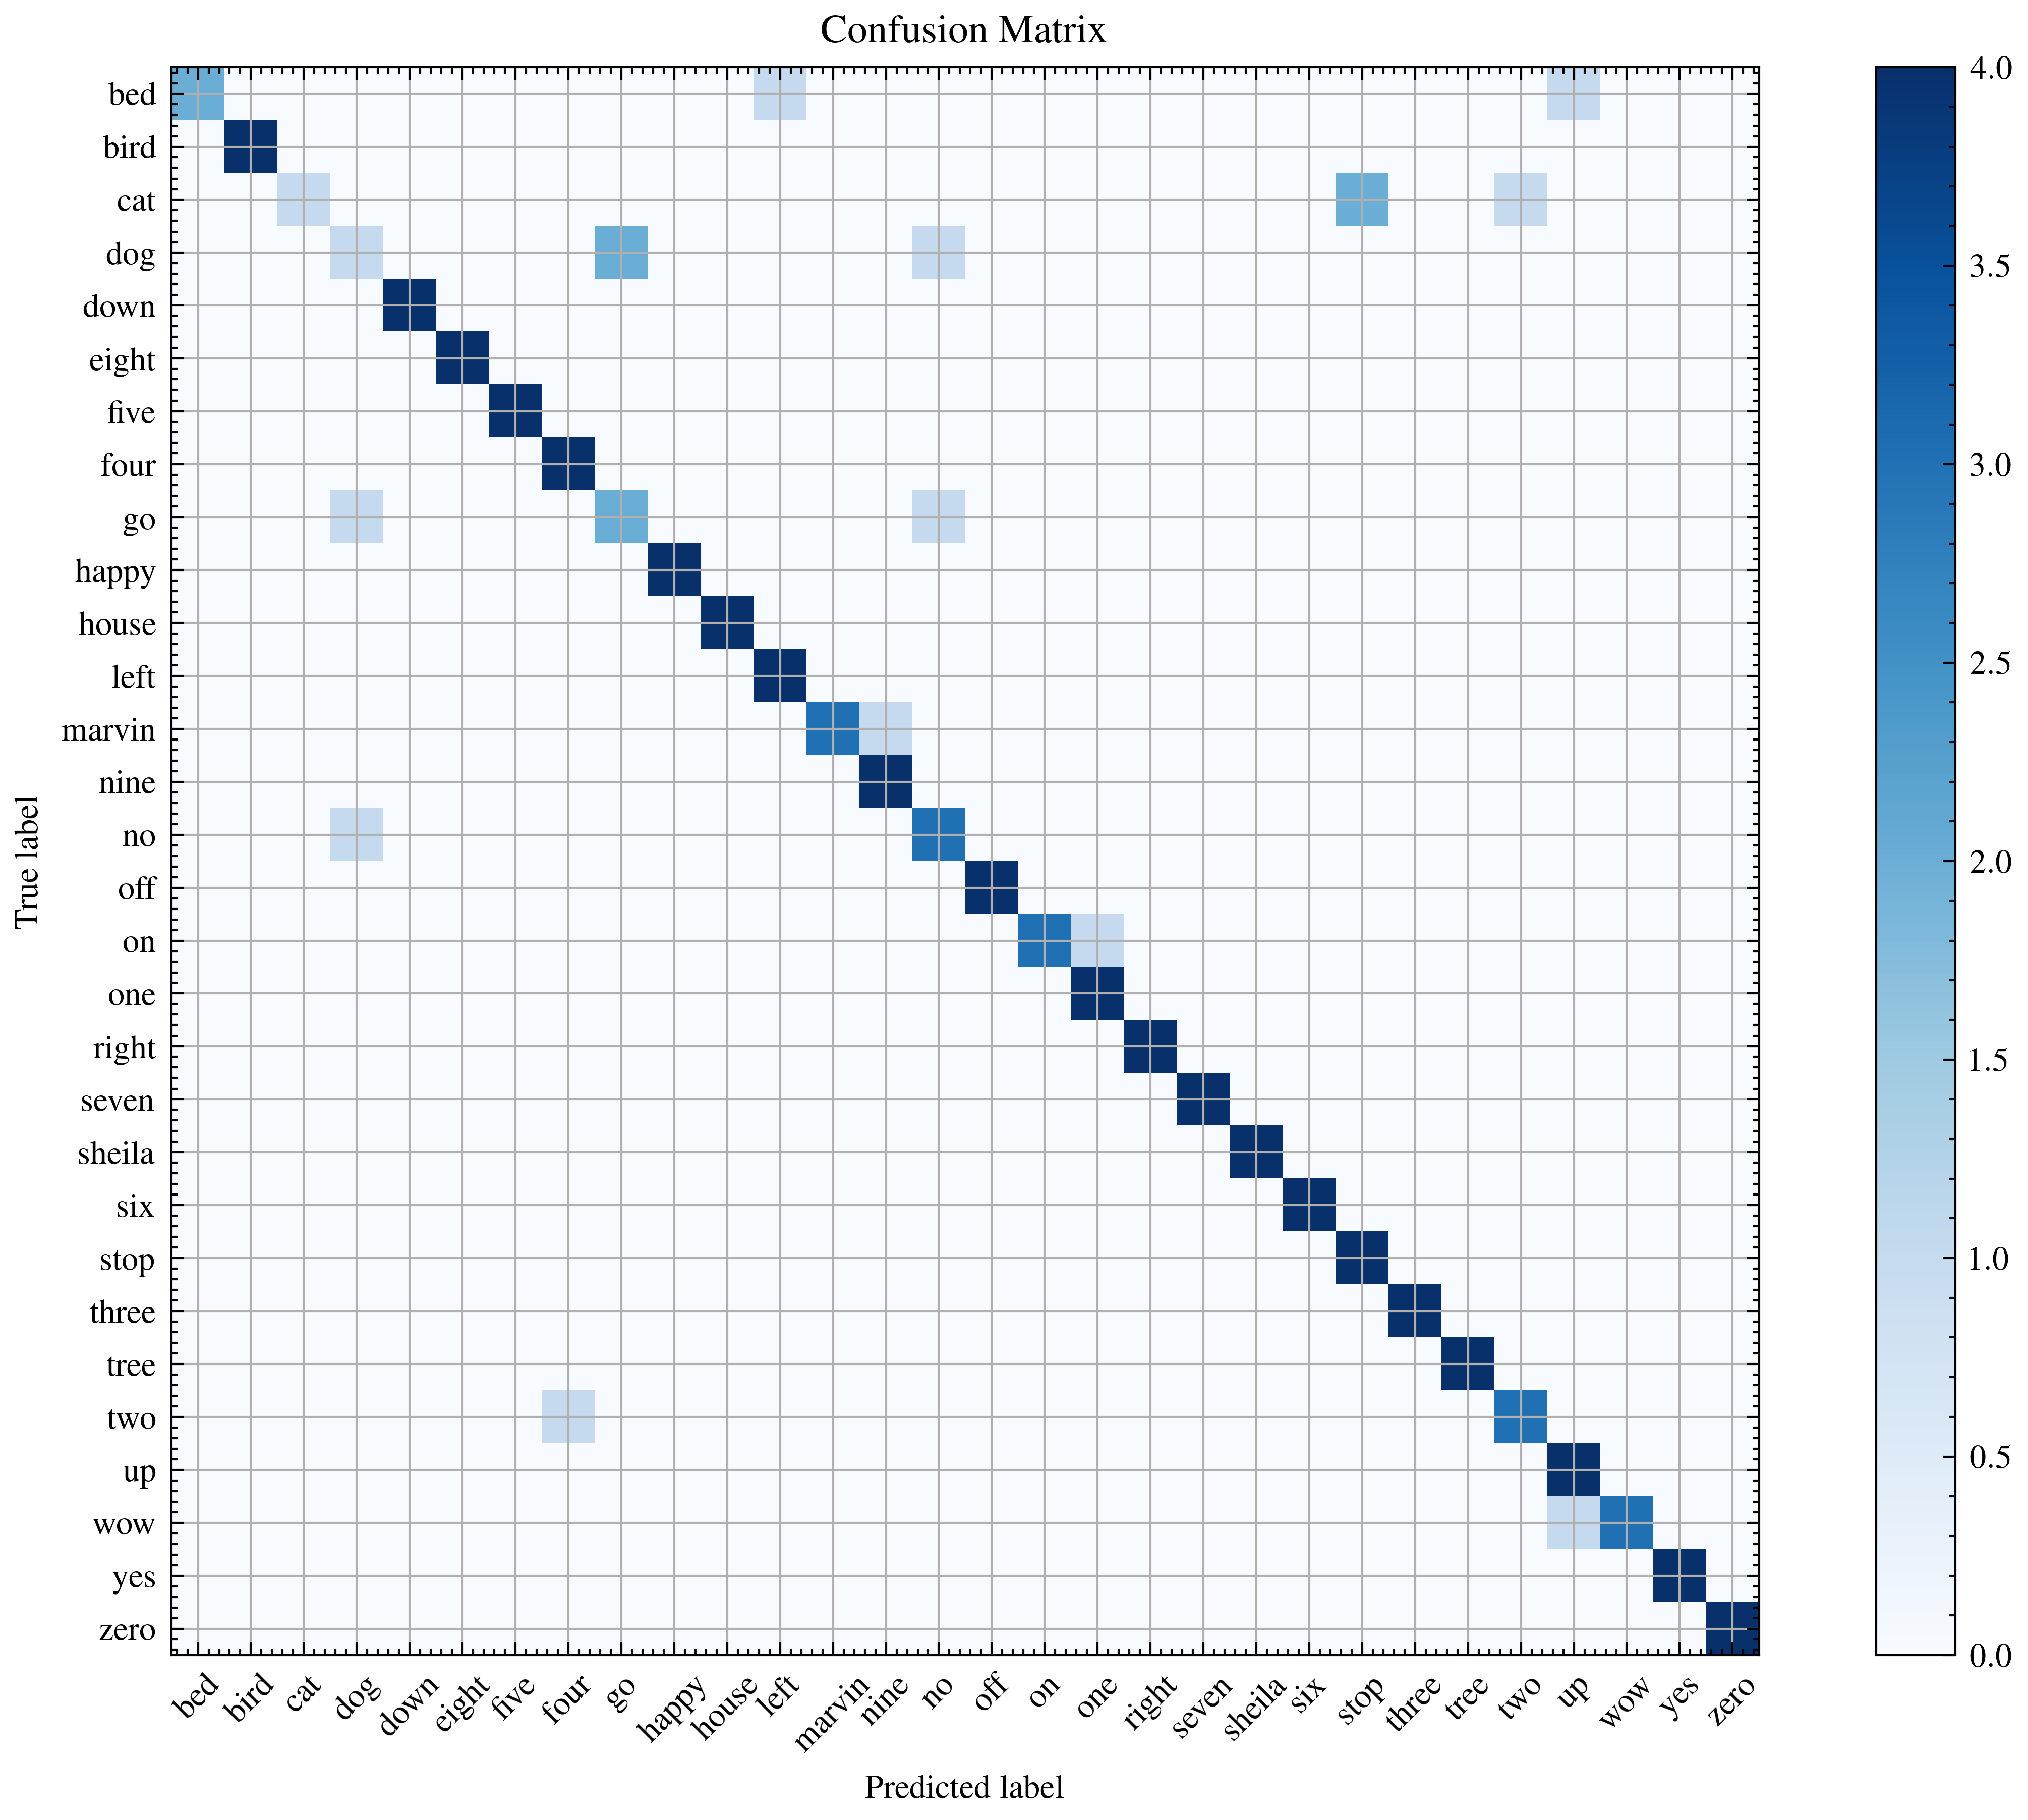

In [15]:
%matplotlib inline
summary(y_true, y_pred, CLASS_LABELS)

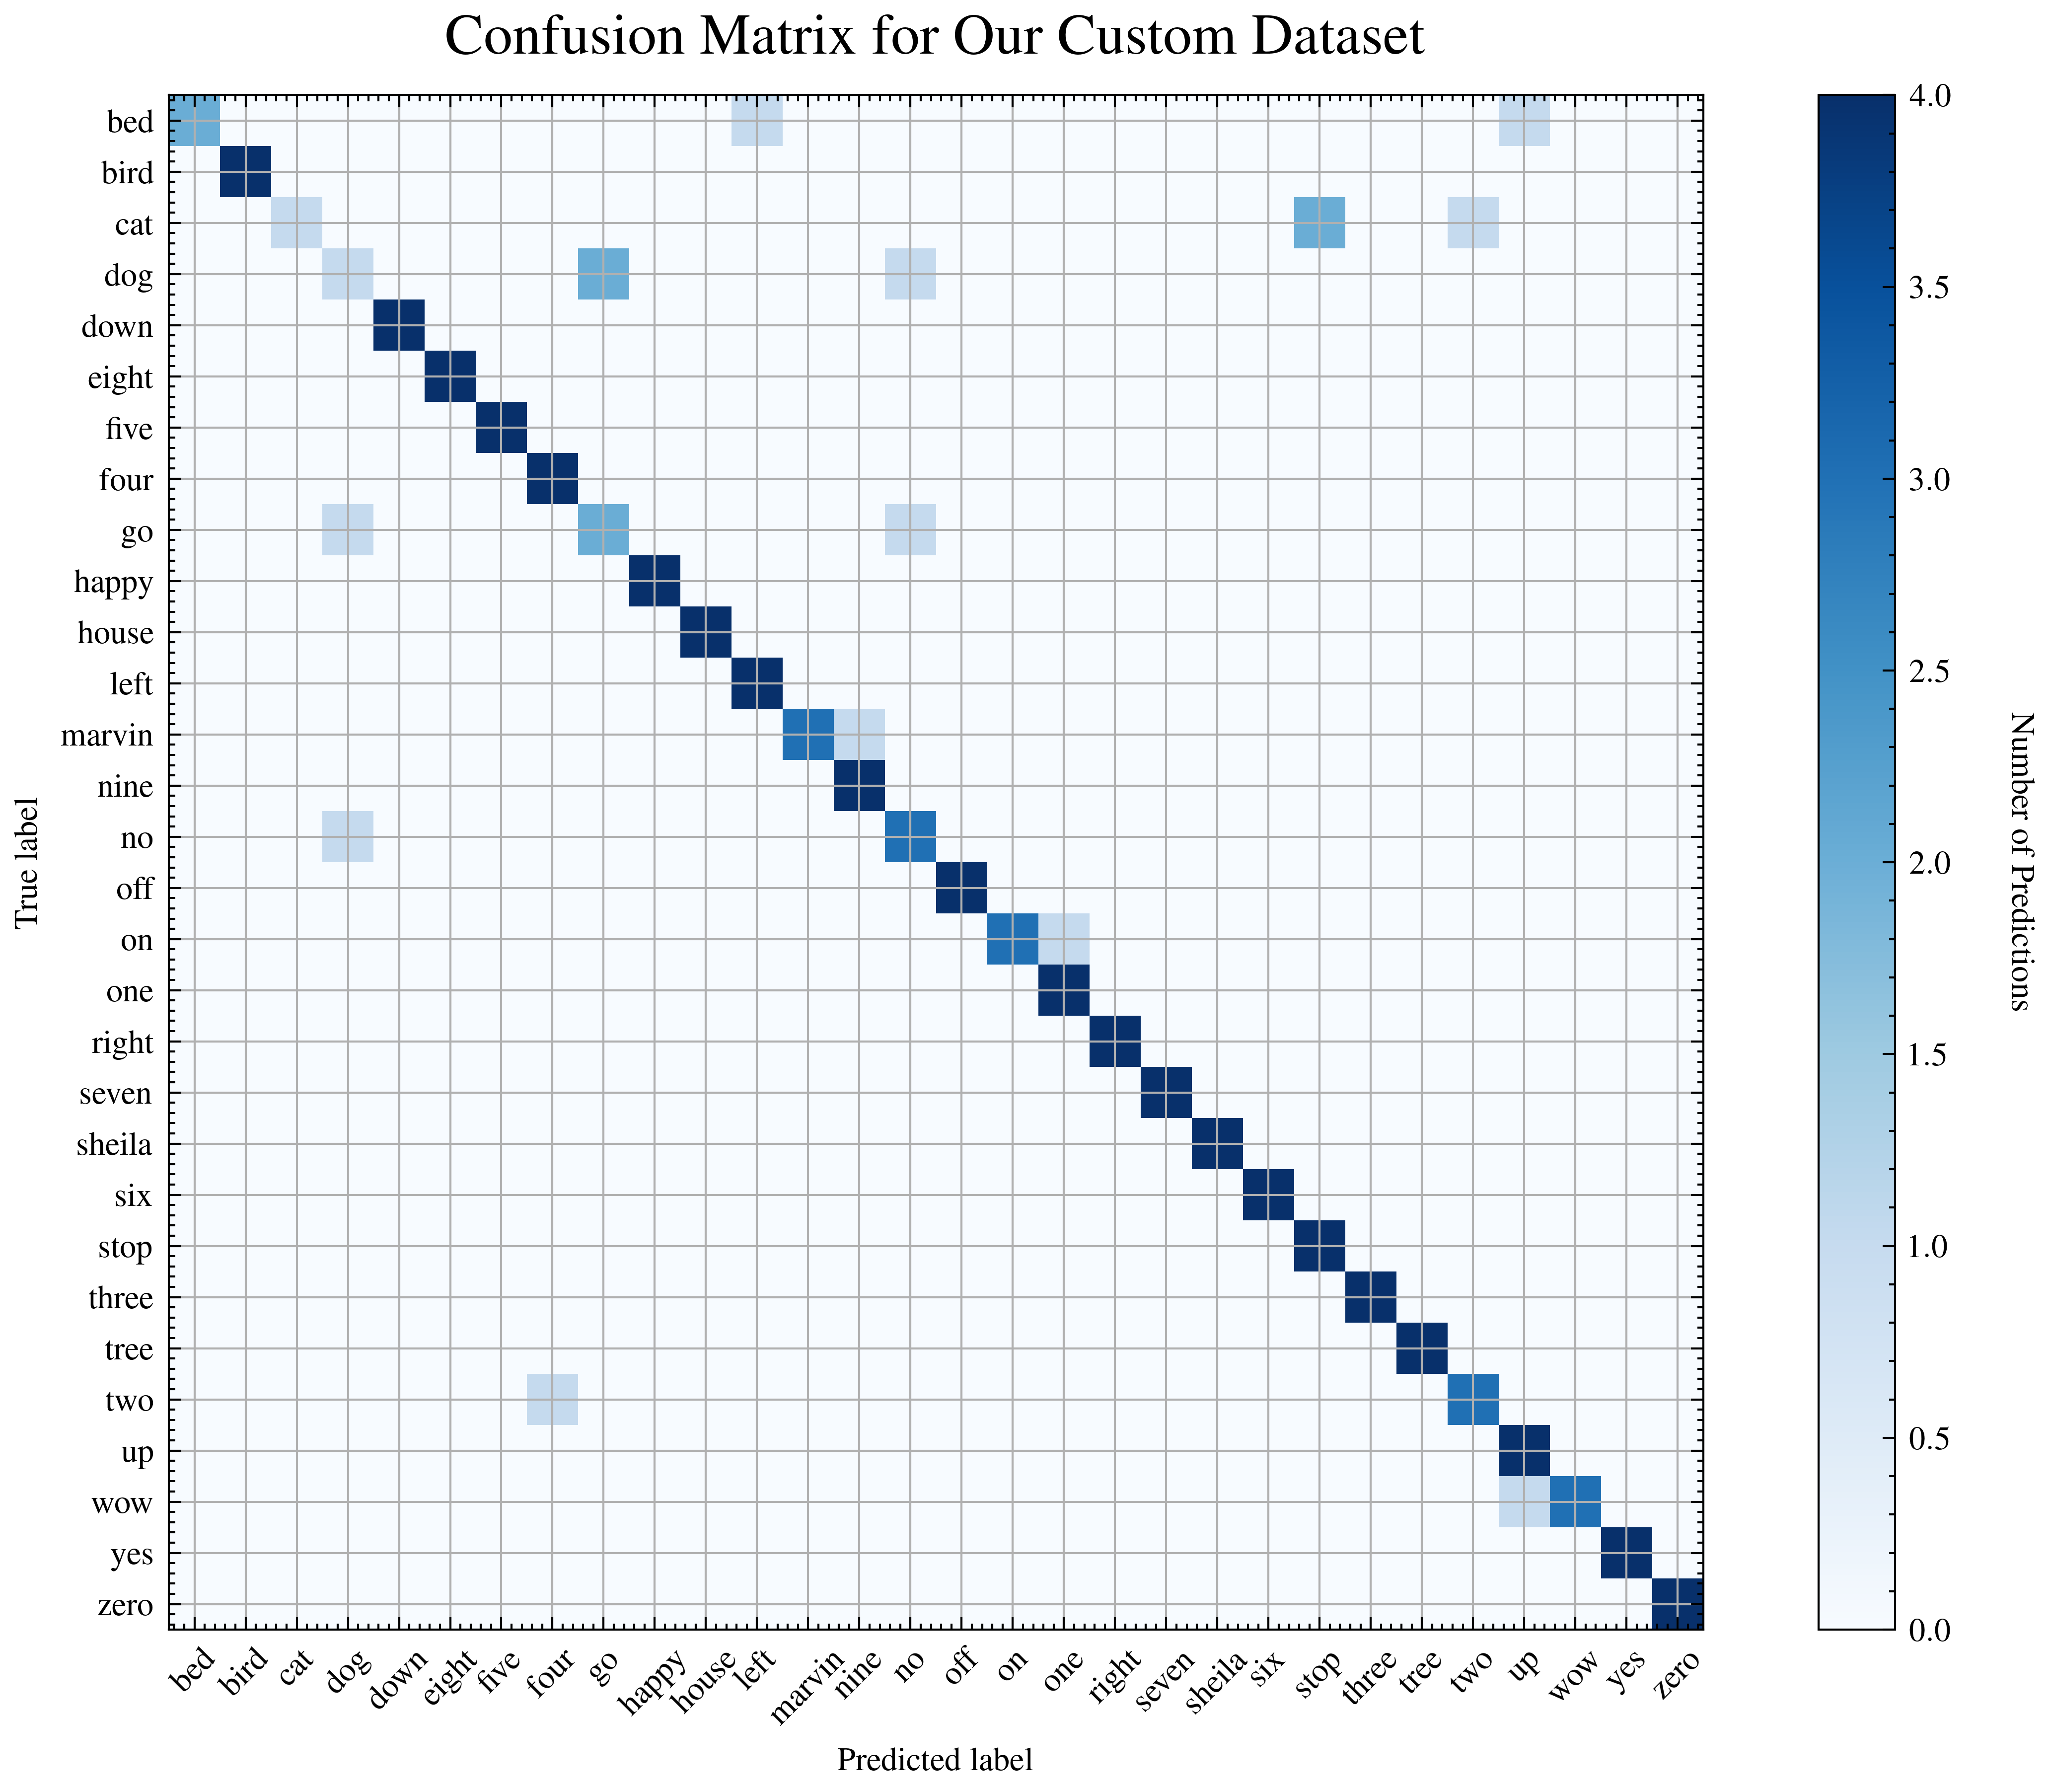

In [16]:

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Our Custom Dataset", pad=10, fontsize=14)
cbar = plt.colorbar()
cbar.set_label('Number of Predictions', rotation=270, labelpad=20)
tick_marks = np.arange(len(CLASS_LABELS))
plt.xticks(tick_marks, CLASS_LABELS, rotation=45)
plt.yticks(tick_marks, CLASS_LABELS)
plt.grid(True)

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.savefig('charts/custom_data_confusion_matrix.png')
plt.show()